<a href="https://colab.research.google.com/github/pojo-25/AdvancedTensorflow/blob/main/Yolov3EfficientDetDeneme_03ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

YoloV3 has been the go to model for image detection use cases in application development because of its small size, quick inference time, and portability. Recently, the Google Brain team has released EfficientDet, which has shown promise to perform better under more stringent computational constraints than YoloV3 on COCO (a general image detection task). 

In this notebook, we put the claims of EfficientDet to the test. We compare the **model size, training time, downstream performance, and inference time** of YoloV3 and EfficientDet-D0 on a custom dataset from Roboflow. To run on your own custom dataset, you only need to change one line of code that you will recieve after uploading your data set to Roboflow!


#### ![Post image](https://i.imgur.com/eisthE4.png)

Image Citation: http://clipart-library.com/ 



### **Data Download** 

We will download our data in two formats from Roboflow. COCO json for EfficientDet and Yolov3 Darknet text. Our data contains examples of labeling chess pieces, which we at Roboflow consider our "hello world" for image detection. 

### **Model training** 

To familiarize with training EfficientDet with Roboflow [see this blog post](incoming). 
To familiarize with training YoloV3 with Roboflow [see this blog post](https://blog.roboflow.ai/training-a-yolov3-object-detection-model-with-a-custom-dataset/)

Both of our implementations of the two models are in pytorch. 

### **Measuring training time** 

In order to measure training time, we train each model to the point of convergence. 

### **Measuring model size**

We look at how much storage is required to host the trained model weights for each implementation

### **Measuring downstream performance**

We evaluate the mAP (mean Average Precision) on our test set split. 

### **Measuring Inference Time** 

We time the average amount of time it takes the model to make inferences on a single shot image detection task. 

### **Conclusion**

What did we find

#### ![Roboflow Workmark](https://i.imgur.com/WHFqYSJ.png)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Set Up Environment

In [ ]:
#look at specs
!df -h


Filesystem      Size  Used Avail Use% Mounted on
overlay          69G   33G   37G  48% /
tmpfs            64M     0   64M   0% /dev
tmpfs           6.4G     0  6.4G   0% /sys/fs/cgroup
shm             5.8G     0  5.8G   0% /dev/shm
tmpfs           6.4G   28K  6.4G   1% /var/colab
/dev/sda1        75G   34G   42G  45% /opt/bin
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware
drive            15G  3.2G   12G  21% /content/drive


In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 b

In [ ]:
!cat /proc/meminfo

MemTotal:       13333596 kB
MemFree:        10200888 kB
MemAvailable:   12459244 kB
Buffers:           91772 kB
Cached:          2309504 kB
SwapCached:            0 kB
Active:           787860 kB
Inactive:        2036296 kB
Active(anon):     391944 kB
Inactive(anon):      380 kB
Active(file):     395916 kB
Inactive(file):  2035916 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:              5252 kB
Writeback:             0 kB
AnonPages:        422884 kB
Mapped:           240804 kB
Shmem:              1036 kB
Slab:             177396 kB
SReclaimable:     134464 kB
SUnreclaim:        42932 kB
KernelStack:        4804 kB
PageTables:         6088 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6666796 kB
Committed_AS:    3252656 kB
VmallocTotal:   34359738367 kB
VmallocUsed:           0 kB
VmallocChunk:          0 kB
Percpu:             1048 kB
AnonHugePages:   

In [ ]:
#first set up for EfficientDet
#our fork of the Tessellate-Imaging image detection library
#!rm -rf Monk_Object_Detection
! git clone https://github.com/roboflow-ai/Monk_Object_Detection.git
# For colab use the command below
# Set up library requirments
! cd Monk_Object_Detection/3_mxrcnn/installation && cat requirements_colab.txt | xargs -n 1 -L 1 pip install
#fixed version of tqdm output for Colab
!pip install --force https://github.com/chengs/tqdm/archive/colab.zip
#IGNORE restart runtime warning, it is indeed installed
#missing a few extra packages that we will need later! 
!pip install efficientnet_pytorch
!pip install tensorboardX


#second set up for YOLOv3
import os
import torch
from IPython.display import Image, clear_output 
print('PyTorch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))
!git clone https://github.com/roboflow-ai/yolov3  # clone


Cloning into 'Monk_Object_Detection'...
remote: Enumerating objects: 3747, done.
remote: Total 3747 (delta 0), reused 0 (delta 0), pack-reused 3747
Receiving objects: 100% (3747/3747), 132.20 MiB | 37.48 MiB/s, done.
Resolving deltas: 100% (800/800), done.
Checking out files: 100% (4032/4032), done.
     |████████████████████████████████| 827.8MB 21kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
  Created wheel for dicttoxml: filename=dicttoxml-1.7.4-cp36-none-any.whl size=17452 sha256=7784ba8a2045ead7b930fd1246aec0eda827185e8af82064a049edb2ced03371
  Stored in directory: /root/.cache/pip/wheels/62/4f/a3/afd4a68f5add45a668c14efa53b64d5cffb2be6bacf993c151
Successfully built dicttoxml
     \ 184kB 13.5MB/s
  Created wheel for tqdm: filename=tqdm-4.28.1-py2.py3-none-any.whl size=47868 sha256=26e1cb284b4a6522a18006ecef6c8a1070feed473a6c6094de0028f2818f1288
  Stored in directory: /tmp/pip-ephem-wheel-cache

# Retrieve Data and Set Up Data Directories

In [ ]:
#input your COCO json link here 
!mkdir ed_data
%cd ed_data
!curl -L "https://app.roboflow.com/ds/hUizd2qo2z?key=bgrDbpVnNd" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

/content/ed_data
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   888  100   888    0     0   1315      0 --:--:-- --:--:-- --:--:--  1313
100 21.9M  100 21.9M    0     0  24.6M      0 --:--:-- --:--:-- --:--:-- 24.6M
Archive:  roboflow.zip
 extracting: README.roboflow.txt     
   creating: test/
 extracting: test/_annotations.coco.json  
 extracting: test/img104_png.rf.14d4a786fbf69dcc683def4e78965a85.jpg  
 extracting: test/img107_png.rf.cd910224fbc56ebb2ef95373e0a5e038.jpg  
 extracting: test/img124_png.rf.de0d384967047520a148f25953ed8cb1.jpg  
 extracting: test/img140_png.rf.87db1a5c1267a7d76ed91372d05c8bc6.jpg  
 extracting: test/img145_png.rf.cb601f2a04d7a401d6a907667f980ac3.jpg  
 extracting: test/img146_png.rf.f23797e3de67ccbf7f1c2143197b3b17.jpg  
 extracting: test/img149_png.rf.e3dc00286bffb2d15d557a2903690bd9.jpg  
 extracting: test/img153_png.rf.c2347312df1b91b

In [ ]:
#we'll download yolo data into content file directory
%cd /content
!curl -L "https://app.roboflow.com/ds/tZIExgiPUm?key=8fFfqsstZK" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip



/content
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   891  100   891    0     0   1164      0 --:--:-- --:--:-- --:--:--  1163
100 21.0M  100 21.0M    0     0  18.9M      0  0:00:01  0:00:01 --:--:-- 18.9M
Archive:  roboflow.zip
 extracting: README.roboflow.txt     
   creating: test/
 extracting: test/_darknet.labels    
 extracting: test/img104_png.rf.14d4a786fbf69dcc683def4e78965a85.jpg  
 extracting: test/img104_png.rf.14d4a786fbf69dcc683def4e78965a85.txt  
 extracting: test/img107_png.rf.cd910224fbc56ebb2ef95373e0a5e038.jpg  
 extracting: test/img107_png.rf.cd910224fbc56ebb2ef95373e0a5e038.txt  
 extracting: test/img124_png.rf.de0d384967047520a148f25953ed8cb1.jpg  
 extracting: test/img124_png.rf.de0d384967047520a148f25953ed8cb1.txt  
 extracting: test/img140_png.rf.87db1a5c1267a7d76ed91372d05c8bc6.jpg  
 extracting: test/img140_png.rf.87db1a5c1267a7d76ed91372d05c

In [ ]:


# img46_png.rf.c2452998eff2a3512c05bc2f9328903d
# img140_png.rf.87db1a5c1267a7d76ed91372d05c8bc6
# img250_png.rf.f07cd896b175a1d79a5d5c57b85ab5dc
# img322_png.rf.f058405cc1a405c1a2d65eccd1f55daa
# img286_png.rf.cacc154c861334991cdd0d5a46372d16



# img147_png.rf.c749ee43aebfdcf667e280e235571dad
# img162_png.rf.31cef160cfd4582a28a271e3f80dc987
# img177_png.rf.c7df2564a3bc35b866f02475347fe64c
# img316_png.rf.5862e214a9c5112b2e34c3a057aedaa9
# img319_png.rf.b3fa8f7663fd6d689c16d619b3d2a5c7

In [ ]:
!pwd

/content


In [ ]:
# %rm  /content/test/img140_png.rf.87db1a5c1267a7d76ed91372d05c8bc6.jpg
# %rm /content/test/img140_png.rf.87db1a5c1267a7d76ed91372d05c8bc6.txt


%rm /content/test/img46_png.rf.c2452998eff2a3512c05bc2f9328903d.jpg
%rm /content/test/img46_png.rf.c2452998eff2a3512c05bc2f9328903d.txt

%rm /content/test/img250_png.rf.f07cd896b175a1d79a5d5c57b85ab5dc.jpg
%rm /content/test/img250_png.rf.f07cd896b175a1d79a5d5c57b85ab5dc.txt

%rm /content/test/img286_png.rf.cacc154c861334991cdd0d5a46372d16.jpg
%rm /content/test/img286_png.rf.cacc154c861334991cdd0d5a46372d16.txt

%rm /content/test/img322_png.rf.f058405cc1a405c1a2d65eccd1f55daa.jpg
%rm /content/test/img322_png.rf.f058405cc1a405c1a2d65eccd1f55daa.txt



rm: cannot remove '/content/test/img46_png.rf.c2452998eff2a3512c05bc2f9328903d.jpg': No such file or directory
rm: cannot remove '/content/test/img250_png.rf.f07cd896b175a1d79a5d5c57b85ab5dc.txt': No such file or directory
rm: cannot remove '/content/test/img286_png.rf.cacc154c861334991cdd0d5a46372d16.jpg': No such file or directory
rm: cannot remove '/content/test/img322_png.rf.f058405cc1a405c1a2d65eccd1f55daa.jpg': No such file or directory


In [ ]:
%cp /content/valid/img147_png.rf.c749ee43aebfdcf667e280e235571dad.jpg /content/test
%cp /content/valid/img147_png.rf.c749ee43aebfdcf667e280e235571dad.txt /content/test

%cp /content/valid/img162_png.rf.31cef160cfd4582a28a271e3f80dc987.jpg /content/test
%cp /content/valid/img162_png.rf.31cef160cfd4582a28a271e3f80dc987.txt /content/test

%cp /content/valid/img177_png.rf.c7df2564a3bc35b866f02475347fe64c.jpg /content/test
%cp /content/valid/img177_png.rf.c7df2564a3bc35b866f02475347fe64c.txt /content/test

%cp /content/valid/img316_png.rf.5862e214a9c5112b2e34c3a057aedaa9.jpg /content/test
%cp /content/valid/img316_png.rf.5862e214a9c5112b2e34c3a057aedaa9.txt /content/test

%cp /content/valid/img319_png.rf.b3fa8f7663fd6d689c16d619b3d2a5c7.jpg /content/test
%cp /content/valid/img319_png.rf.b3fa8f7663fd6d689c16d619b3d2a5c7.txt /content/test

# img147_png.rf.c749ee43aebfdcf667e280e235571dad
# img162_png.rf.31cef160cfd4582a28a271e3f80dc987
# img177_png.rf.c7df2564a3bc35b866f02475347fe64c
# img316_png.rf.5862e214a9c5112b2e34c3a057aedaa9
# img319_png.rf.b3fa8f7663fd6d689c16d619b3d2a5c7


In [ ]:
#set up EfficientDet folder structure
!mkdir ed_data/Chess
!mkdir ed_data/Chess/annotations
!mkdir ed_data/Chess/Annotations
!mkdir ed_data/Chess/Images

%cp ed_data/train/_annotations.coco.json ed_data/Chess/annotations/instances_Images.json
%cp ed_data/train/*.jpg ed_data/Chess/Images/

In [ ]:
!pwd

/content


In [ ]:
#set up yolo folder structure
%cd train
%mkdir labels
%mkdir images
%mv *.jpg ./images/
%mv *.txt ./labels/
%cd images

/content/train
/content/train/images


In [ ]:
# create Ultralytics specific text file of training images
file = open("train_images_roboflow.txt", "w") 
for root, dirs, files in os.walk("."):
    for filename in files:
      # print("../train/images/" + filename)
      if filename == "train_images_roboflow.txt":
        pass
      else:
        file.write("../train/images/" + filename + "\n")
file.close()

In [ ]:

%cd ../../valid
%mkdir labels
%mkdir images

%mv *.jpg ./images/
%mv *.txt ./labels/
%cd images

/content/valid
/content/valid/images


In [ ]:
# create Ultralytics specific text file of validation images
file = open("valid_images_roboflow.txt", "w") 
for root, dirs, files in os.walk("."):
    for filename in files:
      # print("../train/images/" + filename)
      if filename == "valid_images_roboflow.txt":
        pass
      else:
        file.write("../valid/images/" + filename + "\n")
file.close()

%cd ../../yolov3/data
%cat ../../train/_darknet.labels > ../../train/roboflow_data.names

def get_num_classes(labels_file_path):
    classes = 0
    with open(labels_file_path, 'r') as f:
      for line in f:
        classes += 1
    return classes

# update the roboflow.data file with correct number of classes
import re

num_classes = get_num_classes("../../train/_darknet.labels")
with open("roboflow.data") as f:
    s = f.read()
with open("roboflow.data", 'w') as f:
    
    # Set number of classes num_classes.
    s = re.sub('classes=[0-9]+',
               'classes={}'.format(num_classes), s)
    f.write(s)

%cat roboflow.data

/content/yolov3/data
classes=1
train=../train/images/train_images_roboflow.txt
valid=../valid/images/valid_images_roboflow.txt
names=../train/roboflow_data.names


# Measuring Training Time

In [ ]:
%cd ../

/content/yolov3


In [ ]:
#training YOLOv3 model
#on Tesla P100-PCIE-16GB
#based on previous experiments on our validaiton set we think the model converges completely in 100 epochs
!python3 train.py --data data/roboflow.data --epochs 20
#total training time 24.5 min

# 0.458 hours. 27.5 min

Namespace(accumulate=4, adam=False, batch_size=16, bucket='', cache_images=False, cfg='cfg/yolov3-spp.cfg', data='data/roboflow.data', device='', epochs=20, evolve=False, img_size=[416], multi_scale=False, name='', nosave=False, notest=False, rect=False, resume=False, single_cls=False, var=None, weights='weights/yolov3-spp-ultralytics.pt')
Using CUDA device0 _CudaDeviceProperties(name='Tesla T4', total_memory=15079MB)

2021-01-29 12:05:46.316726: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
Model Summary: 225 layers, 6.29987e+07 parameters, 6.29987e+07 gradients
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0   1897      0 --:--:-- --:--:-- --:--:--  1888
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0    

In [ ]:
%cd /content/
#now train EfficientDet model

/content


In [ ]:
import os
import sys
sys.path.append("Monk_Object_Detection/4_efficientdet/lib/");
from train_detector import Detector
gtf = Detector();

#directs the model towards file structure
root_dir = "./";
coco_dir = "ed_data/Chess";
img_dir = "./";
set_dir = "Images";



In [ ]:
gtf.Train_Dataset(root_dir, coco_dir, img_dir, set_dir, batch_size=8, image_size=416, use_gpu=True)
gtf.Model();

#ed_data/Chess/annotations/instances_Images.json

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth



Loaded pretrained weights for efficientnet-b0


In [ ]:
%%time
gtf.Set_Hyperparams(lr=0.0001, val_interval=1, es_min_delta=0.0, es_patience=0)
gtf.Train(num_epochs=20, model_output_dir="trained/");
#total training time 18.3 min
#25.2 min

Monk_Object_Detection/4_efficientdet/lib/src/model.py:251: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if len(inputs) == 2:
Monk_Object_Detection/4_efficientdet/lib/src/utils.py:84: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  image_shape = np.array(image_shape)
Monk_Object_Detection/4_efficientdet/lib/src/utils.py:96: TracerWarning: torch.from_numpy results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this fu


CPU times: user 7min 33s, sys: 1min 23s, total: 8min 56s
Wall time: 9min 32s


# Measuring Model Size

In [ ]:
#size of yolov3 in our test
#number of parameters 65,252,682
!du --block-size=1MB yolov3/weights/last.pt

253	yolov3/weights/last.pt


In [ ]:
#size of EfficientDet-D0 in our test
#number of parameters 3,900,000 
!du --block-size=1MB trained/signatrix_efficientdet_coco.pth

17	trained/signatrix_efficientdet_coco.pth


In [ ]:
!du --block-size=1MB trained/signatrix_efficientdet_coco.onnx

1	trained/signatrix_efficientdet_coco.onnx


In [ ]:
#param multiplier 17x
#model size 15x 

In [ ]:
!pwd

/content


# Measuring Inference Time

In [ ]:
##first inference with effficientDet
import os
import sys
sys.path.append("Monk_Object_Detection/4_efficientdet/lib/");
from infer_detector import Infer
gtf = Infer();
#our trained model weights are in here in onxx format
gtf.Model(model_dir="trained/")
#extract class list from our annotations
import json
with open('ed_data/train/_annotations.coco.json') as json_file:
    data = json.load(json_file)
class_list = []
for category in data['categories']:
  class_list.append(category['name'])


In [ ]:
!ls test

_darknet.labels
img104_png.rf.14d4a786fbf69dcc683def4e78965a85.jpg
img104_png.rf.14d4a786fbf69dcc683def4e78965a85.txt
img107_png.rf.cd910224fbc56ebb2ef95373e0a5e038.jpg
img107_png.rf.cd910224fbc56ebb2ef95373e0a5e038.txt
img124_png.rf.de0d384967047520a148f25953ed8cb1.jpg
img124_png.rf.de0d384967047520a148f25953ed8cb1.txt
img145_png.rf.cb601f2a04d7a401d6a907667f980ac3.jpg
img145_png.rf.cb601f2a04d7a401d6a907667f980ac3.txt
img146_png.rf.f23797e3de67ccbf7f1c2143197b3b17.jpg
img146_png.rf.f23797e3de67ccbf7f1c2143197b3b17.txt
img147_png.rf.c749ee43aebfdcf667e280e235571dad.jpg
img147_png.rf.c749ee43aebfdcf667e280e235571dad.txt
img149_png.rf.e3dc00286bffb2d15d557a2903690bd9.jpg
img149_png.rf.e3dc00286bffb2d15d557a2903690bd9.txt
img153_png.rf.c2347312df1b91bf79e253de41f4b770.jpg
img153_png.rf.c2347312df1b91bf79e253de41f4b770.txt
img155_png.rf.319f9f71a2c56621bdb45489503c8130.jpg
img155_png.rf.319f9f71a2c56621bdb45489503c8130.txt
img156_png.rf.5ea3bad30fed8b44034fd55edfd83923.jpg
img156_png.rf.5

In [ ]:
#44 ms 
img_path = "ed_data/test/img89_png.rf.c2452f559ed6aacc4f13ddcbe9540ec1.jpg";
duration, scores, labels, boxes = gtf.Predict(img_path, class_list, vis_threshold=0.6);

Done. (0.042s)


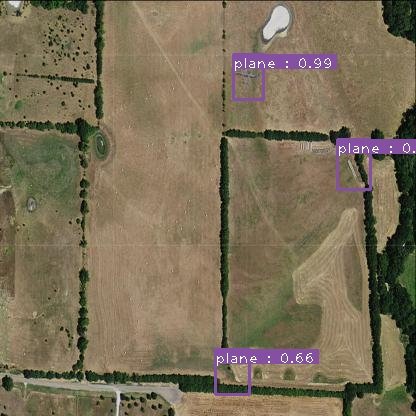

In [ ]:
#looks pretty good! 
from IPython.display import Image
Image(filename='output.jpg') 

In [ ]:
%cd yolov3/

/content/yolov3


In [ ]:
!pwd

/content/yolov3


In [ ]:
#now inference with YoloV3
#inference time is defined within detect.py 
#49 ms 
!python3 detect.py --weights weights/last.pt --source=../test/img89_png.rf.c2452f559ed6aacc4f13ddcbe9540ec1.jpg --names=../train/roboflow_data.names  --iou-thres 0.2 

Namespace(agnostic_nms=False, cfg='cfg/yolov3-spp.cfg', classes=None, conf_thres=0.3, device='', fourcc='mp4v', half=False, img_size=416, iou_thres=0.2, names='../train/roboflow_data.names', output='output', save_txt=False, source='../test/img89_png.rf.c2452f559ed6aacc4f13ddcbe9540ec1.jpg', view_img=False, weights='weights/last.pt')
Using CUDA device0 _CudaDeviceProperties(name='Tesla T4', total_memory=15079MB)

Model Summary: 225 layers, 6.29987e+07 parameters, 6.29987e+07 gradients
/content/yolov3/utils/utils.py:532: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  i, j = (pred[:, 5:] > conf_thres).nonzero().t()
image 1/1 ../test/img89_png.rf.c2452f559ed6aacc4f13ddcbe9540ec1.jpg: 416x416 2 planes, Done. (0.043s)
Results saved to /content/yolov3/output
Done. (0.053s)


img89_png.rf.c2452f559ed6aacc4f13ddcbe9540ec1.jpg


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


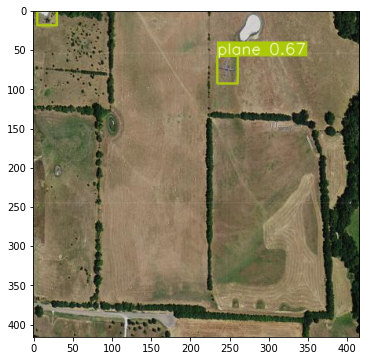

In [ ]:
# import libraries for display
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Image
from glob import glob
import random
import PIL
# plot just one random image prediction
filename = random.choice(os.listdir('./output'))
print(filename)
Image('./output/' + filename)

# grab all images from our output directory
images = [ PIL.Image.open(f) for f in glob('./output/*') ]
# convert images to numPy
def img2array(im):
    if im.mode != 'RGB':
        im = im.convert(mode='RGB')
    return np.fromstring(im.tobytes(), dtype='uint8').reshape((im.size[1], im.size[0], 3))

# create array of numPy images
np_images = [ img2array(im) for im in images ]

# plot ALL results in test directory (NOTE: adjust figsize as you please)
for img in np_images:
    plt.figure(figsize=(8, 6))
    plt.imshow(img)



In [ ]:
# %cp -r /content/valid /content/valid2

In [ ]:
%cd /content/yolov3

/content/yolov3


In [ ]:
#measuring inference accross test set

for f in os.listdir('../test'):
  if f.endswith('.jpg'):
    !python3 detect.py --weights weights/last.pt --source=../test/{f} --names=../train/roboflow_data.names --iou-thres 0.2 


In [ ]:
%cd .. 
for f in os.listdir('test'):
  if f.endswith('.jpg'):
    duration, scores, labels, boxes = gtf.Predict('test/'+f, class_list, vis_threshold=0.2);

In [ ]:
#average inference time YOLOv3 39 ms
#average inference time efficientDet 37 ms

# Measuring Performance

In [ ]:
%cd /content/
!git clone https://github.com/Cartucho/mAP

/content
Cloning into 'mAP'...
remote: Enumerating objects: 908, done.
remote: Total 908 (delta 0), reused 0 (delta 0), pack-reused 908
Receiving objects: 100% (908/908), 14.71 MiB | 41.04 MiB/s, done.
Resolving deltas: 100% (321/321), done.


In [ ]:
%cd /content/

/content


In [ ]:
%cp test/_darknet.labels mAP/scripts/extra/class_list.txt
%cp test/_darknet.labels mAP/input/


In [ ]:
%rm -rf mAP/input/ground-truth/
%mkdir mAP/input/ground-truth/

In [ ]:
%rm -rf mAP/input/images
%mkdir mAP/input/images

In [ ]:
%rm -rf mAP/input/images-optional/
%mkdir mAP/input/images-optional/

In [ ]:
%cp test/*txt mAP/input/ground-truth/

In [ ]:
%cp test/*jpg mAP/input/images-optional/

In [ ]:
%cp test/*jpg mAP/input/images/

In [ ]:
#%ls test
%cp test/*jpg mAP/input/images-optional/

In [ ]:
%cd mAP/scripts/extra/

/content/mAP/scripts/extra


In [ ]:
!python convert_gt_yolo.py

Conversion completed!


In [ ]:
%cd /content/mAP

/content/mAP


In [ ]:
%cat input/ground-truth/1c0060ef868bdc326ce5e6389cb6732f_jpg.rf.a07af6147d4a79376c182d2d95c639ec.txt


cat: input/ground-truth/1c0060ef868bdc326ce5e6389cb6732f_jpg.rf.a07af6147d4a79376c182d2d95c639ec.txt: No such file or directory


In [ ]:
%cd /content

/content


In [ ]:
%rm -rf mAP/input/detection-results/

In [ ]:

%mkdir mAP/input/detection-results/

In [ ]:
for f in os.listdir('test'):
  if f.endswith('.jpg'):
    duration, scores, labels, boxes = gtf.Predict('test/'+f, class_list, vis_threshold=0.2);
    scores = scores.tolist()
    boxes = boxes.tolist()
    labels = labels.tolist()
    with open('mAP/input/detection-results/' + f[:-4] + '.txt', 'w') as out_file:
      #write detection result
      for i in range(len(scores)):
        #print(scores)
        line = class_list[labels[i]] + ' ' + str(scores[i]) + ' ' + str(' '.join([str(j) for j in boxes[i]]))
        out_file.write(line)
        if i < len(scores) - 1:
          out_file.write('\n')



Done. (0.041s)
Done. (0.036s)
Done. (0.035s)
Done. (0.035s)
Done. (0.037s)
Done. (0.035s)
Done. (0.035s)
Done. (0.034s)
Done. (0.037s)
Done. (0.044s)
Done. (0.033s)
Done. (0.033s)
Done. (0.033s)
Done. (0.033s)
Done. (0.033s)
Done. (0.033s)
Done. (0.037s)
Done. (0.037s)
Done. (0.035s)
Done. (0.039s)
Done. (0.036s)
Done. (0.036s)
Done. (0.036s)
Done. (0.040s)
Done. (0.037s)
Done. (0.036s)
Done. (0.036s)
Done. (0.036s)
Done. (0.035s)
Done. (0.038s)
Done. (0.034s)
Done. (0.042s)
Done. (0.035s)
Done. (0.035s)
Done. (0.042s)
Done. (0.034s)
Done. (0.036s)
Done. (0.034s)
Done. (0.036s)
Done. (0.034s)
Done. (0.033s)
Done. (0.034s)
Done. (0.035s)
Done. (0.034s)
Done. (0.038s)
Done. (0.034s)
Done. (0.035s)
Done. (0.034s)
Done. (0.034s)


In [ ]:
%cd mAP/

/content/mAP


In [ ]:
#evaluation results for EfficientDet
!python main.py -na

62.51% = plane AP 
mAP = 62.51%
<Figure size 640x480 with 1 Axes>


In [ ]:

%cd ..

/content


In [ ]:
!pwd

/content/mAP


In [ ]:
%cd /content/yolov3/

/content/yolov3


In [ ]:
# %rm -rf yolov3  # remove existing
# !git clone https://github.com/ultralytics/yolov3 && cd yolov3

In [ ]:
!python3 detect.py --weights weights/last.pt --source=../test/ --names=../train/roboflow_data.names --save-txt --iou-thres 0.2 --output outputLast

Namespace(agnostic_nms=False, cfg='cfg/yolov3-spp.cfg', classes=None, conf_thres=0.3, device='', fourcc='mp4v', half=False, img_size=416, iou_thres=0.2, names='../train/roboflow_data.names', output='outputLast', save_txt=True, source='../test/', view_img=False, weights='weights/last.pt')
Using CUDA device0 _CudaDeviceProperties(name='Tesla T4', total_memory=15079MB)

Model Summary: 225 layers, 6.29987e+07 parameters, 6.29987e+07 gradients
/content/yolov3/utils/utils.py:532: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  i, j = (pred[:, 5:] > conf_thres).nonzero().t()
image 1/49 ../test/img104_png.rf.14d4a786fbf69dcc683def4e78965a85.jpg: 416x416 6 planes, Done. (0.046s)
image 2/49 ../test/img107_png.rf.cd910224fbc56ebb2ef95373e0a5e038.jpg: 416x416 3 planes, Done. (0.035s)
image 3/49 ../test/img124_png.rf.de0

In [ ]:
#reorder and write to mAP calc
%cd ..
%rm -rf mAP/input/detection-results/
%mkdir mAP/input/detection-results/

for f in os.listdir('yolov3/outputLast/'):
  if f.endswith('txt'):
    print(f)
    with open('mAP/input/detection-results/' + f[:-8] + '.txt', 'w') as out_file:
      with open('yolov3/outputLast/' + f) as read_file:
        lines = read_file.readlines()
        for line in lines:
          line = line.split()
          out_file.write(class_list[int(line[4]) + 1] + ' ' + line[5] + ' ' + ' '.join(line[0:4]))
          out_file.write('\n')



/content
img156_png.rf.5ea3bad30fed8b44034fd55edfd83923.jpg.txt
img66_png.rf.201f69848a4be613f71f22e52797ae20.jpg.txt
img177_png.rf.c7df2564a3bc35b866f02475347fe64c.jpg.txt
img289_png.rf.c04b736b83edc9556b990a047f43ccba.jpg.txt
img60_png.rf.3765f8a5d13117d1935333b2a252f64f.jpg.txt
img499_png.rf.cfb37215c6d75395ebba1f269802f5f3.jpg.txt
img149_png.rf.e3dc00286bffb2d15d557a2903690bd9.jpg.txt
img371_png.rf.9d41bbdff72a015979dbf297c8b72101.jpg.txt
img311_png.rf.9aee206fec9e75b5f78e77b68b1c30c8.jpg.txt
img73_png.rf.9e327b4e8695bb66194d2e6a937e4ee9.jpg.txt
img383_png.rf.0b1e8f619e46c37ce8e6433e4ccb77d0.jpg.txt
img29_png.rf.7494a07052a3792908eb68e9faf07a23.jpg.txt
img484_png.rf.3bda1ed1cd6cb0dbab9c001f69ecc665.jpg.txt
img400_png.rf.34fa9ef18437561d4922f69c1dec2e5a.jpg.txt
img162_png.rf.31cef160cfd4582a28a271e3f80dc987.jpg.txt
img455_png.rf.1229b3e1b0f8989250785d45eeff1ae0.jpg.txt
img374_png.rf.e3b8b2afcafb8dad107392e575a1753c.jpg.txt
img463_png.rf.6ba81ea15d5236d00483602c15e08c07.jpg.txt
img25

In [ ]:
%cd /content/mAP
#!python scripts/extra/intersect-gt-and-dr.py
!python main.py -na

/content/mAP
67.26% = plane AP 
mAP = 67.26%
<Figure size 640x480 with 1 Axes>


In [ ]:
%cp /content/valid2/images/*jpg /content/valid2

In [ ]:
%cp /content/valid2/labels/*txt /content/valid2

In [ ]:
%rm -rf /content/valid2/images

In [ ]:


# img46_png.rf.c2452998eff2a3512c05bc2f9328903d
# img140_png.rf.87db1a5c1267a7d76ed91372d05c8bc6
# img250_png.rf.f07cd896b175a1d79a5d5c57b85ab5dc
# img322_png.rf.f058405cc1a405c1a2d65eccd1f55daa
# img286_png.rf.cacc154c861334991cdd0d5a46372d16



# img147_png.rf.c749ee43aebfdcf667e280e235571dad
# img162_png.rf.31cef160cfd4582a28a271e3f80dc987
# img177_png.rf.c7df2564a3bc35b866f02475347fe64c
# img316_png.rf.5862e214a9c5112b2e34c3a057aedaa9
# img319_png.rf.b3fa8f7663fd6d689c16d619b3d2a5c7